# Exploration des données

_ismaël Bonneau et Issam Benamara_

### Avant de commencer à travailler avec les données, il est bon d'avoir un aperçu détaillé de leur organisation

Nous disposons d'une base de données de sous-tires d'épisodes de séries organisés par série, saison.
Tous les sous-titres sont au format .srt, qui contient des timestamp et des identifiants de ligne. Après un prétraitement, 
tous les fichiers de la base sont transformés pour ne plus contenir qu'une réplique par ligne.
Nous filtrons également tous les épisodes présents dans la base pour ne garder que ceux en langue anglaise.

Nous regardons plusieurs informations:
- **nombre total de séries, saisons, épisodes**
- **distribution du nombre de saisons et d'épisodes**
- **nombre moyen de lignes de dialogue et distribution du nombre de lignes de dialogue**

puis, ensuite:

#### Recherche d'éléments caractéristiques d'une série

Nous continuons notre exploration du dataset avec l'affinage du nettoyage des données et les premières analyses: 
tout d'abord, nous cherchons à déterminer des façons de reconnaitre une série: Nous cherchons ce qui différencie les séries les unes des autres.
Pour cela, nous nous intéressons à plusieurs paramètres, ou features:
- **nombre de mots différents** (taille du vocabulaire d'une série)
- **nombre moyen de mots dans un épisode**
- **longueur moyenne des répliques**
- **mots caractéristiques d'une série**: termes ayant le score tf-idf le plus élevé
- **entités nommées** éventuellement (cela peut rejoindre l'idée précédente de tf-idf)
- bonus (est-ce faisable?) mesurer le **registre de langage d'une série**

**L'objectif** est de chercher à extraire des caractéristiques des séries, comme son **thème**, sa **catégorie** (action/romance/comédie/policier/science-fiction...) et se déterminer d'autres **paramètres déterminant** dans la catégorisation d'une série, afin de déterminer des métriques pertinentes pour définir une similarité entre séries.

Nous nous servirons de plusieurs sources de données: 

- Une base de données de **sous-titres**, qui nous servira à analyser le contenu même d'une série à travers les lignes de dialogue de ses épisodes

- Une base de données de **résumé de la série/saison**, en nous servant de l'API du site Omdb, qui, couplé aux sous-titres, nous servira à mieux mettre en évidence le contenu de la série.

In [1]:
import codecs
import glob
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
import seaborn as sns
#using https://github.com/amueller/word_cloud
from wordcloud import WordCloud

plt.style.use('seaborn-white')
%matplotlib inline

#dataset path
path = "dataset"

### Affichons un aperçu du contenu d'un fichier:

##### version brute .srt

##### version transformée

In [4]:
with open(path+"/217_Game_of_Thrones/01/01__Winter_is_Coming.lines", "r") as file:
    lines = file.readlines()
    for line in lines[:15]:
        print(line.rstrip())

Easy, boy.
What do you expect?
They're savages.
One lot steals a goat from another lot, before you know it they're ripping each other to pieces.
I've never seen wildlings do a thing like this.
I never seen a thing like this, not ever in my life.
How close did you get?
- Close as any man would.
- We should head back to the wall.
Do the dead frighten you?
Our orders were to track the wildlings.
We tracked them.
They won't trouble us no more.
You don't think he'll ask us how they died?
Get back on your horse.


<img src="images/nblignesdedialogue.png">


#### On constate donc que la majorité des séries n'ont pas plus de 3 saisons, et que très peu de séries ont plus d'une cinquantaine d'épisodes.

En réalité, l'immense majorité des séries n'a qu'une seule saison. Une grande majorité des séries n'a que peu d'épisodes (moins d'une vingtaine).
Les épisodes sont assez longs en moyenne, on constate une distribution proche d'une normale centrée sur 634 avec un écart-type plutôt réduit (295).

In [ ]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_short, remove_stopwords
from gensim.parsing.preprocessing import strip_numeric, strip_non_alphanum, strip_multiple_whitespaces

import random

from sklearn.feature_extraction.text import TfidfVectorizer

CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_short,
                  strip_numeric, strip_non_alphanum, remove_stopwords]

Voici une liste de quelques séries célèbres: Nous nous servirons de ces séries comme base d'analyse. Cela présente comme intérêt le fait de pouvoir comparer/vérifier nos résultats avec nos connaissances de ces séries, que nous avont vu pour certaines (que le lecteur se rassure, nous n'avons pas regardé the Vampire Diaries).

In [7]:
series = ["2567_House", "2956_Criminal_Minds", "1262_Lost", "175_The_Walking_Dead", "76_Breaking_Bad", "196_Smallville",
"217_Game_of_Thrones", "1906_The_Vampire_Diaries", "3280_Peaky_Blinders", "1704_Rick_and_Morty", "1039_Narcos",
              "1845_Sherlock_(2010)", "1701_Outlander", "3314_Shameless", "818_Gomorra_(2014)", "413_Dexter",
              "2123_Sense8", "121_Suits", "2469_The_Simpsons", "1718_South_Park", "3259_Stargate_SG-1"]

In [8]:
corpus = []
for serie in series:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.lines")
    if len(listepisodes) > 30:
        random.shuffle(listepisodes)
        listepisodes = listepisodes[:30]
    text = ""
    for episode in listepisodes:
        with open(episode, "r", encoding="utf-8") as file:
            text += " " + " ".join(preprocess_string(file.read(), CUSTOM_FILTERS))
    corpus.append(text)
print(len(corpus))

In [8]:
vectorizer = TfidfVectorizer(lowercase=True, binary=False, analyzer='word', use_idf = True, stop_words='english')

X = vectorizer.fit_transform(corpus)

customstopwords = ["yes", "yeah", "hmm", "hey", "nah", "oh", "uh", "okay", "okey", "ye", "hey", "na", "ca", "ok",
                  "got", "come", "back", "up"]
customstopwords += stopwords.words("english")

vectorizer = TfidfVectorizer(lowercase=True, binary=False, analyzer='word', use_idf = True, stop_words=customstopwords)

X = vectorizer.fit_transform(corpus)

#merci pour le bout de code ci-dessous à:
#codeforfrankfurt, https://github.com/codeforfrankfurt/PolBotCheck/blob/master/polbotcheck/word_cluster.py
#et vive Francfort
def wordlCloudPerSerie(vectorizer, corpus, series, words_n):
    terms = vectorizer.get_feature_names()

    word_cloud_per_serie = {}

    for serie in range(len(corpus)):
        feature_index = X[serie, :].nonzero()[1]
        tfidf_scores = zip(feature_index, [X[serie, x] for x in feature_index])
        doc_terms = []
        for word, score in [(terms[i], score) for (i, score) in tfidf_scores]:
            doc_terms.append((word, score))
        important_terms = [(word, score) for word, score in sorted(doc_terms, key=lambda x: x[1], reverse=True)][:words_n]
        word_cloud_per_serie[series[serie]] = important_terms
    return word_cloud_per_serie

word_cloud_per_serie = wordlCloudPerSerie(vectorizer, corpus, series, 30)

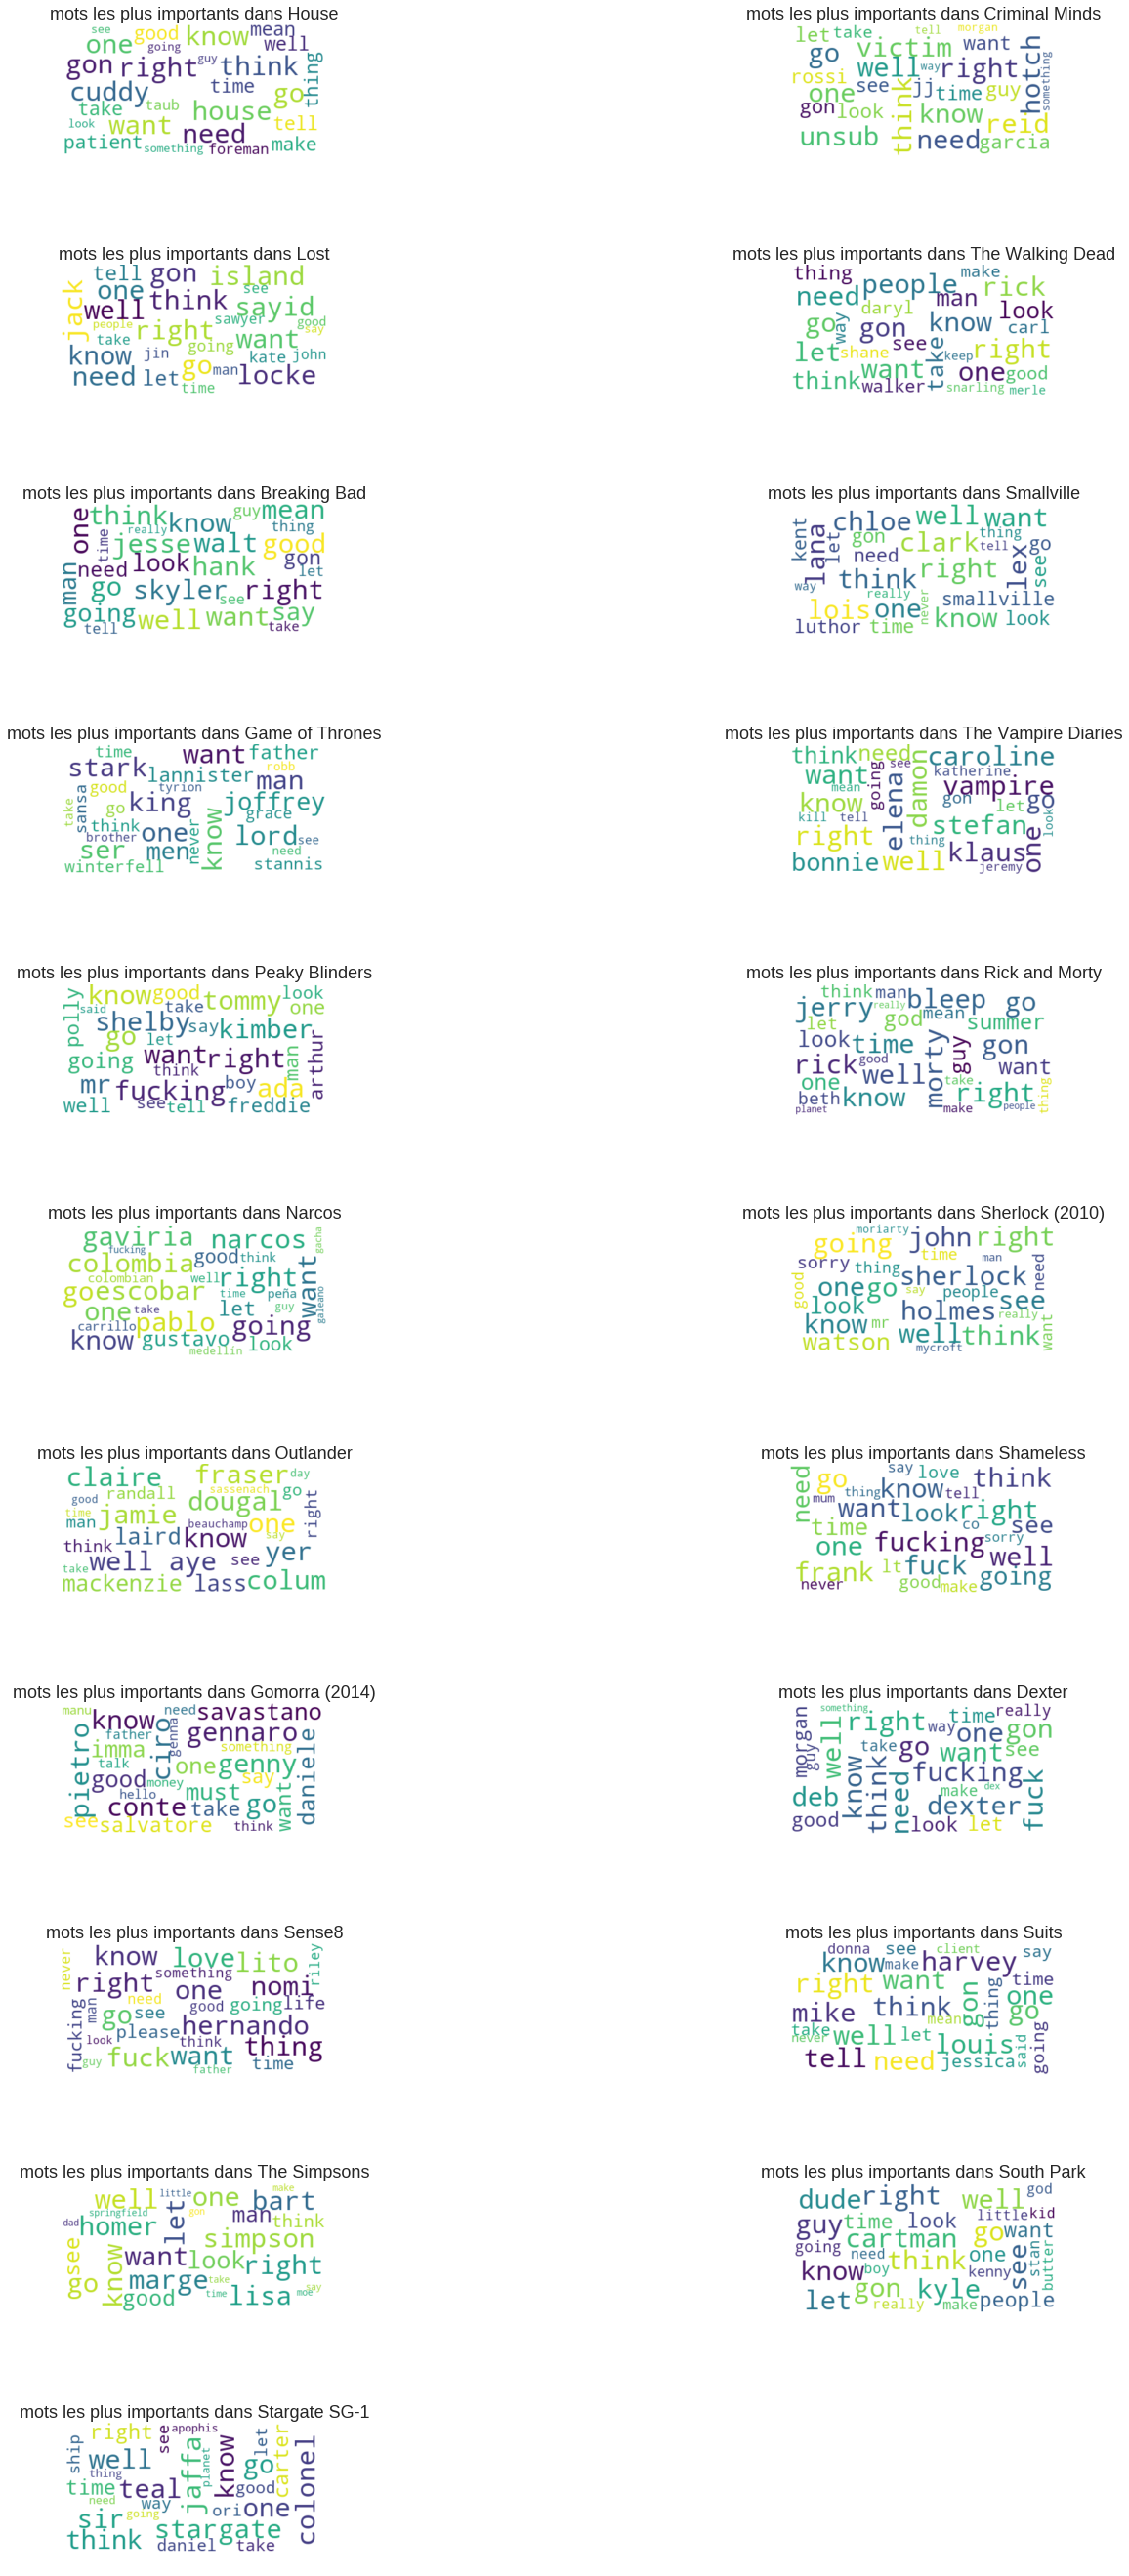

In [9]:
plt.figure(figsize=(30,45))
index = 1
for serie, value in word_cloud_per_serie.items():
    text = " ".join([word for word, tf_idf in value])
    nomserie = " ".join(serie.split("_")[1:])
    wordcloud = WordCloud(background_color="white", max_font_size=40).generate(text)
    plt.subplot(11, 2, index)
    plt.title("mots les plus importants dans "+nomserie, fontsize=18)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    index += 1
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.8, wspace=0.05)
plt.show()

#### Résultat:

De nombreux mots de la langue courante ressortent. On peut noter par exemple la présence de "good", "got", "yeah", "come", "think", "tell", "going" dans plusieurs séries. Cela n'est pas gênant car mot de la langue courante ne veut pas forcément dire "stopword" au sens mot d'apportant pas d'information. Le mot "yeah" par exemple peut être assez révélateur de l'époque à laquelle se déroule la série et du registre de langue des personnages.

On observe que les noms des **personnages principaux** ressortent immédiatement: "JJ", "Garcia", "Reid", "Hotch" pour Esprits criminels, "Pablo", "Gaviria", "Gustavo", "Carrillo", "Escobar" dans Narcos, etc...

On observe également que certains **éléments de langage "familier"** resortent: "fucking" dans Narcos, Peaky Blinders, Shameless, Dexter (qui  emploient un langage chatié) par exemple, "fuck" également.

Ces mots **trop particuliers à une série** (personnages de la série, noms de lieux fictifs et donc propres à une série...) doivent être retirés du corpus si nous voulons pas trop pénaliser notre mesure de similarité. 

Il faut revanche faire attention à ne pas retirer de mots importants au sens tf-idf mais n'étant pas particulier à une seule série.

### Expérimentation: extraction d'entités nommées

Cherchons à extraire les "entités nommées" de la série. Etant donné la difficulté de la tâche, nous allons tester plusieurs méthodes expérimentales. Commençons par la plus simple:

- Essayons d'extraire les mots trop particuliers à une série en filtrant un peu mieux que précédemment:

Les mots les plus spécifiques sont simplements les mots qui ont un **df à 1** (c'est à dire qu'ils sont présents uniquement dans cette série).

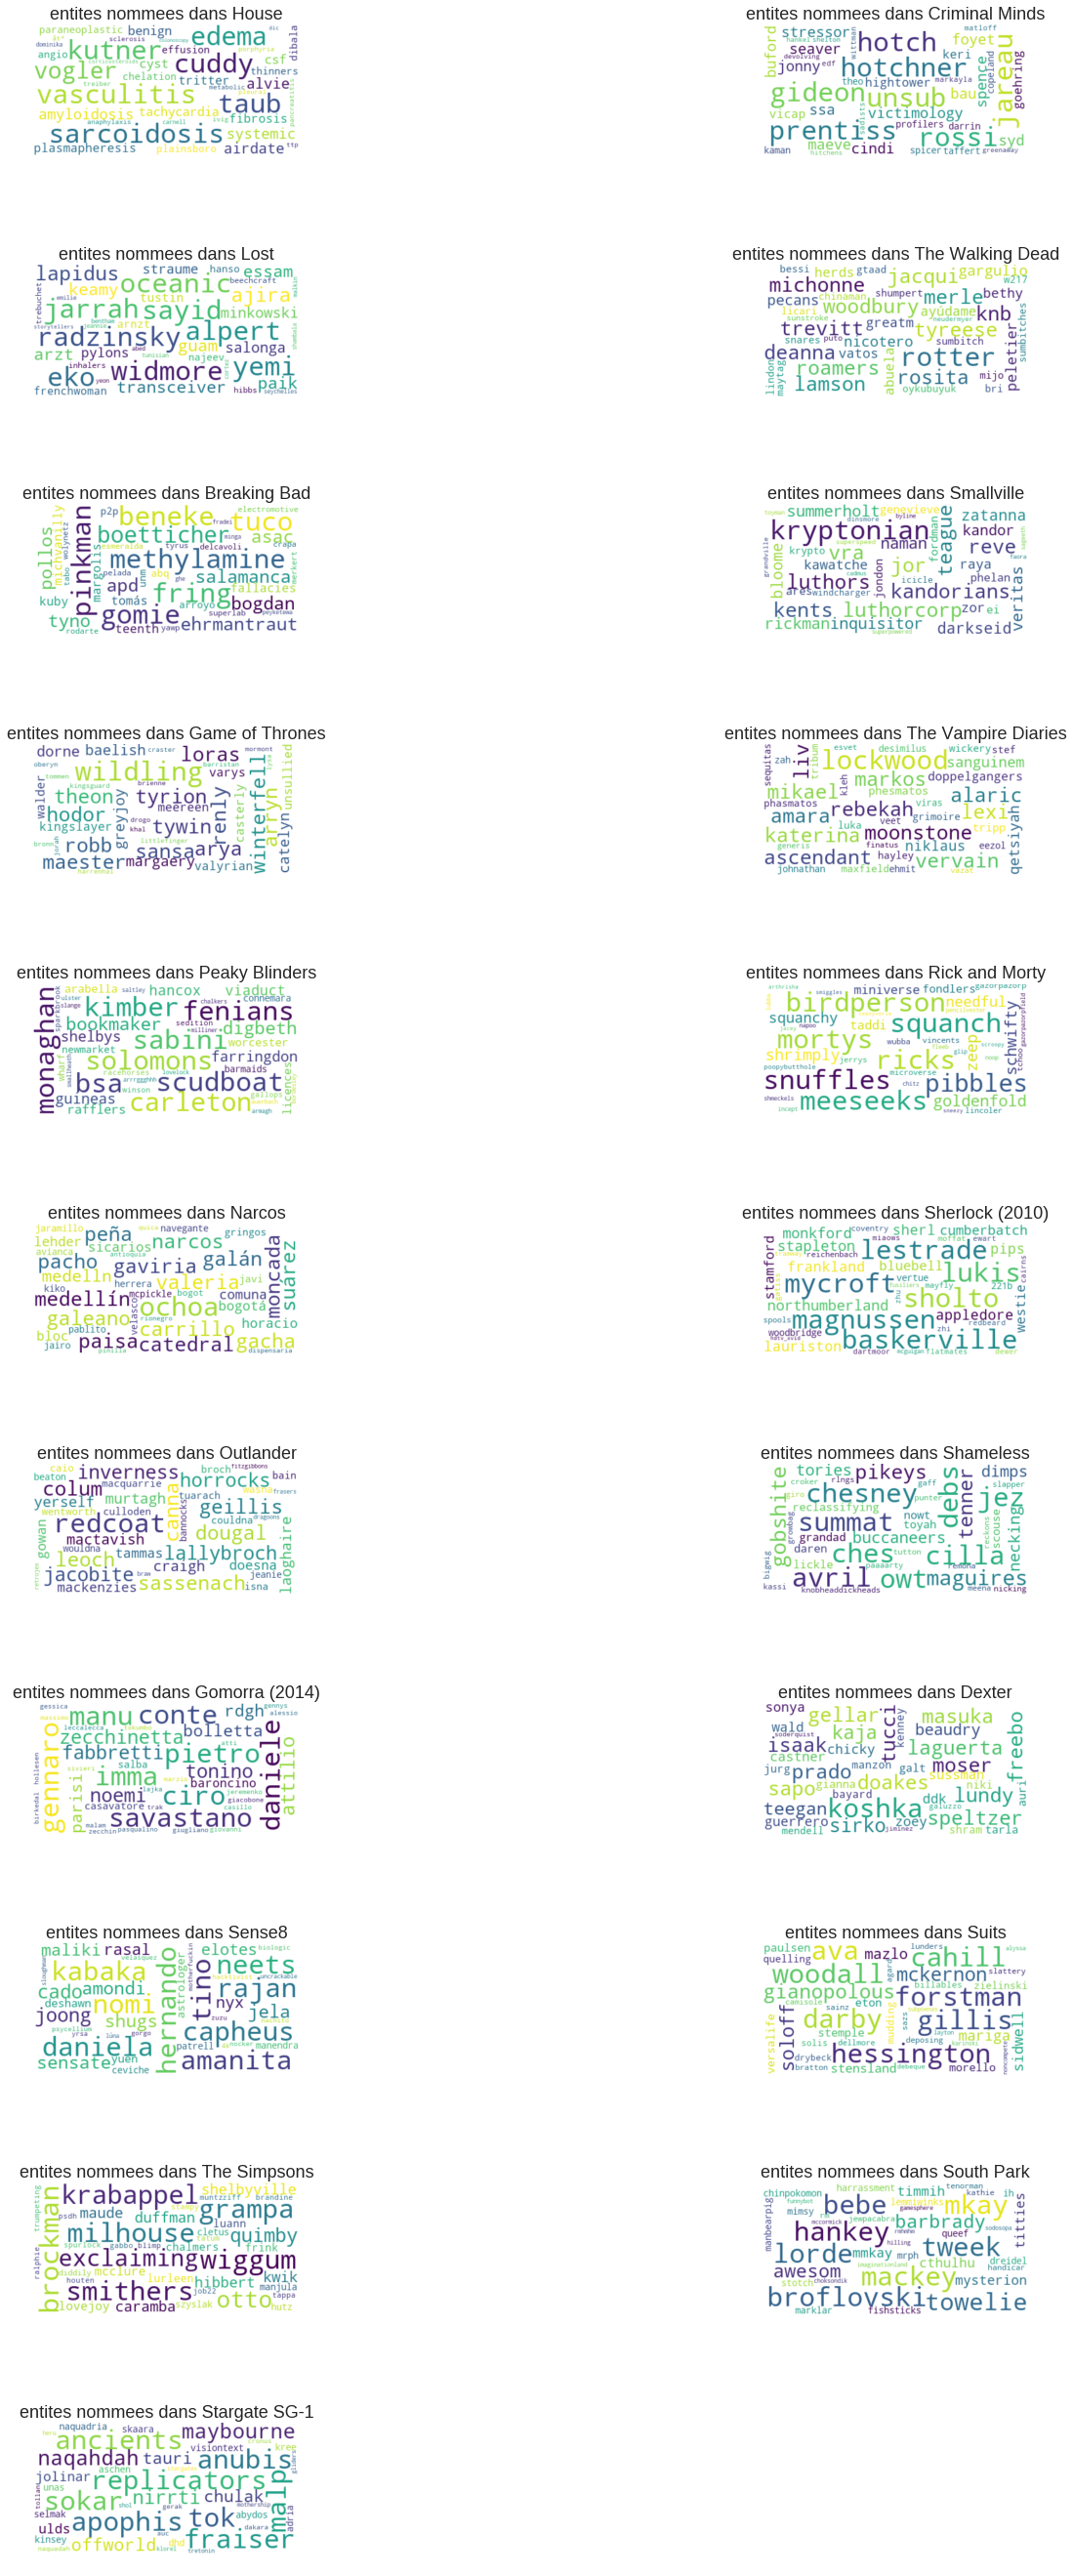

In [40]:
#mettons max_df à 1 pour ne garder que les mots particuliers à une seule série
vectorizer = TfidfVectorizer(lowercase=True, 
                             binary=False,
                             analyzer='word',
                             use_idf = True,
                             stop_words=customstopwords,
                             max_df = 1)

X = vectorizer.fit_transform(corpus)

#gardons seulement les 40 mots les plus importants: il y a surement bien moins
#de 40 personnages/lieux par série
word_cloud_per_serie = wordlCloudPerSerie(vectorizer, corpus, series, 40)

plt.figure(figsize=(30,45))
index = 1
for serie, value in word_cloud_per_serie.items():
    text = " ".join([word for word, tf_idf in value])
    nomserie = " ".join(serie.split("_")[1:])
    wordcloud = WordCloud(background_color="white", max_font_size=40).generate(text)
    plt.subplot(11, 2, index)
    plt.title("entites nommees dans "+nomserie, fontsize=18)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    index += 1
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.8, wspace=0.05)
plt.show()

In [41]:
print("mots les plus particuliers dans les Simpsons:\n", word_cloud_per_serie["2469_The_Simpsons"][:10], "\n")
print("mots les plus particuliers dans Smallville:\n", word_cloud_per_serie["196_Smallville"][:10], "\n")
print("mots les plus particuliers dans Game of Thrones:\n", word_cloud_per_serie["217_Game_of_Thrones"][:10])

mots les plus particuliers dans les Simpsons:
 [('milhouse', 0.6668004413230775), ('smithers', 0.40972075310213196), ('grampa', 0.3605140940285916), ('wiggum', 0.1938139836978222), ('brockman', 0.14561154215639494), ('krabappel', 0.11347658112877673), ('exclaiming', 0.11247236359666365), ('otto', 0.10544284087187218), ('quimby', 0.09740910061496764), ('shelbyville', 0.09339223048651536)] 

mots les plus particuliers dans Smallville:
 [('jor', 0.6062307026036163), ('luthorcorp', 0.598508018494016), ('kryptonian', 0.33979810082240913), ('luthors', 0.12742428780840342), ('reve', 0.10811757753440289), ('kents', 0.09846422239740266), ('kandorians', 0.09653355137000258), ('teague', 0.0888108672604024), ('vra', 0.07915751212340214), ('inquisitor', 0.07336549904120197)] 

mots les plus particuliers dans Game of Thrones:
 [('winterfell', 0.3397231662758135), ('sansa', 0.3217483955733895), ('tyrion', 0.27681146881732954), ('robb', 0.2678240834661175), ('tywin', 0.20131743186714873), ('theon', 0.

#### Observons le résultat:

Bien mieux. La plupart des mots sélectionnés sont des noms de personnage/lieux/entreprises particuliers à la série (ou aux autres séries connectées au même univers, comme par exemple pour les super héros).
Pour smallville, Luthor, Luthorcorp, Darkseid, etc se retrouvent sélectionnés. Pour de nombreuses séries, cette méthode marche très bien, en revanche pour house, on remarque que les termes sélectionnés contiennent presque uniquement les noms de maladie. On retrouve bien en revanche Taub, Alvie, Vogler... qui sont des personnages de la série.

Un gros problème se pose: où sont Bart, Marge, Homer, Lisa, Krusty, dans les simpsons? et Klark, Kent, dans Smallville? il semblerait que ces mots n'aient pas un df de 1 dans notre corpus (Pour "Lisa", "Kent", c'est envisageable... mais peu probable pour le reste). 
> Se pourrait-il que ces termes se retrouvent dans d'autres séries du corpus?

Pouvons-nous améliorer cela, en gardant uniquement les mots "non anglais"? Cela pourrait permettre de ne garder que des noms de famille, ou de personnages fictifs ("darkseid"...)

- Essayons de réduire la taille du corpus pour obtenir une meilleure extraction des noms de personnage:

In [46]:
liste = ["2469_The_Simpsons", "196_Smallville", "217_Game_of_Thrones"]

corpus = []

for serie in liste:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.tokens") #texte lemmatisé!
    text = ""
    for episode in listepisodes:
        with open(episode, "r", encoding="utf-8") as file:
            text += " " + file.read()
    corpus.append(text)

vectorizer = TfidfVectorizer(lowercase=True, 
                             binary=False,
                             analyzer='word',
                             use_idf = True,
                             stop_words=customstopwords,
                             max_df = 1)
 
X = vectorizer.fit_transform(corpus)
word_cloud_per_serie = wordlCloudPerSerie(vectorizer, corpus, liste, 40)

In [47]:
print("mots les plus particuliers dans les Simpsons:\n", word_cloud_per_serie["2469_The_Simpsons"][:10], "\n")
print("mots les plus particuliers dans Smallville:\n", word_cloud_per_serie["196_Smallville"][:10], "\n")
print("mots les plus particuliers dans Game of Thrones:\n", word_cloud_per_serie["217_Game_of_Thrones"][:10])

mots les plus particuliers dans les Simpsons:
 [('homer', 0.8192210565130098), ('simpson', 0.4466117962606583), ('springfield', 0.1780280307041941), ('moe', 0.15725538901765185), ('milhouse', 0.10694664743305735), ('homie', 0.09445060516849677), ('flanders', 0.09396374637896843), ('skinner', 0.07351567721877841), ('smithers', 0.06491450527044451), ('grampa', 0.05793619595387173)] 

mots les plus particuliers dans Smallville:
 [('lex', 0.9695572586762107), ('metropolis', 0.16751317080098047), ('luthorcorp', 0.11591313158103558), ('kryptonian', 0.065434832344133), ('krypton', 0.05533917249675248), ('mercer', 0.03028697954214156), ('nell', 0.0299130662144608), ('luthors', 0.024678279626930158), ('reve', 0.020939146350122558), ('kandorians', 0.018695666384038)] 

mots les plus particuliers dans Game of Thrones:
 [('ser', 0.3855833094574608), ('lannister', 0.3024419083556958), ('joffrey', 0.3024419083556958), ('stannis', 0.23014503783242188), ('winterfell', 0.22773514214831275), ('sansa', 0

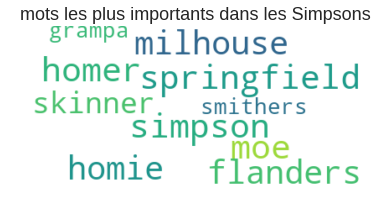

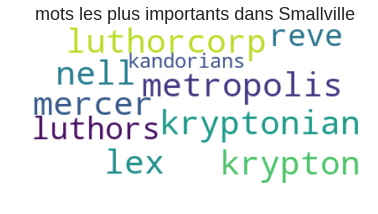

In [58]:
text = " ".join([word for word, score in word_cloud_per_serie["2469_The_Simpsons"][:10]])
wordcloud = WordCloud(background_color="white", max_font_size=40).generate(text)
plt.title("mots les plus importants dans les Simpsons", fontsize=18)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

text = " ".join([word for word, score in word_cloud_per_serie["196_Smallville"][:10]])
wordcloud = WordCloud(background_color="white", max_font_size=40).generate(text)
plt.title("mots les plus importants dans Smallville", fontsize=18)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<img src="images/supermanquichiale.jpg" alt="superman" width="400"/>

#### Résultat:

Bien meilleur! les "vrais" personnages principaux ressortent (mais **toujours pas de Clark Kent!** le fan de superman que je suis est triste)
Cette méthode fonctionne néanmoins et nous allons la garder pour la suite.

#### Observons maintenant quelques différences de forme des séries:

- voici d'abord la longueur moyenne des lignes des séries:

In [4]:
corpus = []

for serie in series:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.lines")
    text = ""
    for episode in listepisodes:
        with codecs.open(episode, "r", "utf-8") as file:
            text += " " + file.read()
    corpus.append(text)

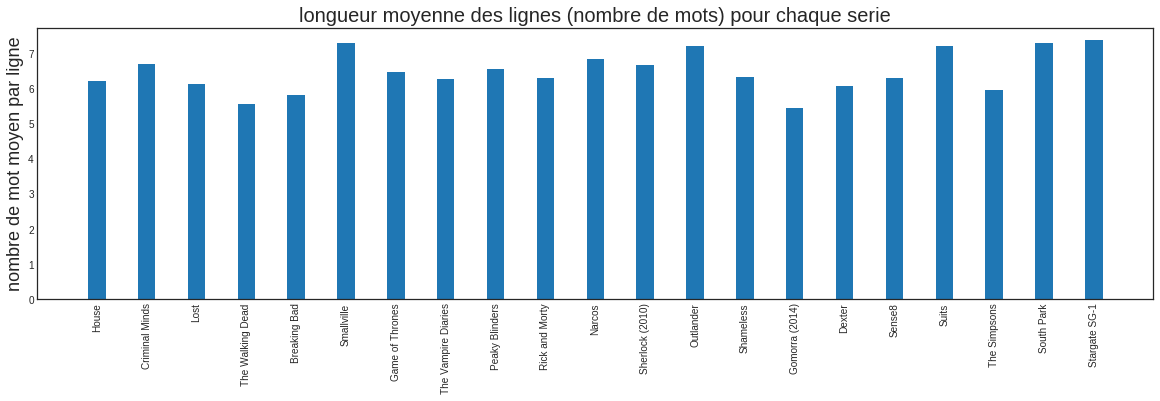

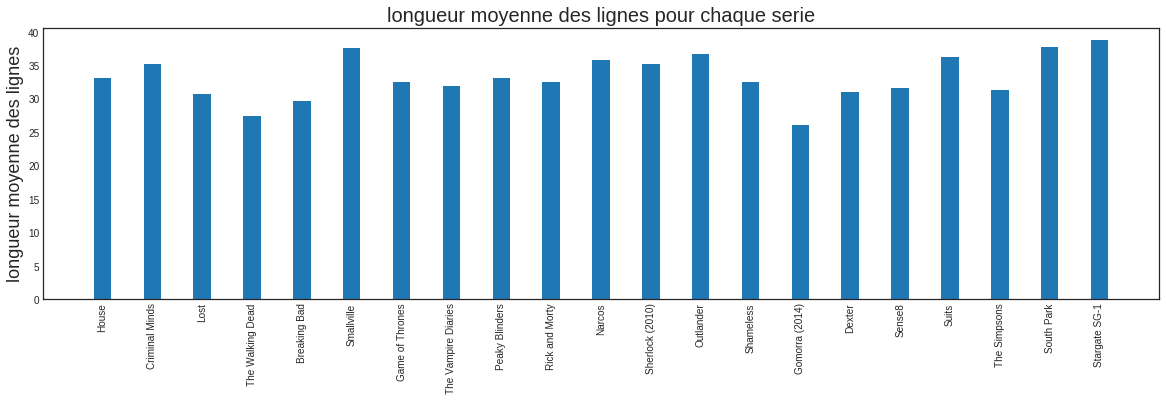

In [5]:
longueurs = []
for i in range(len(series)):
    longueurs.append(np.mean(np.array([len(x.split(" ")) for x in corpus[i].split('\n')])))
    
plt.figure(figsize=(20,5))
plt.ylabel("nombre de mot moyen par ligne", fontsize=18)
plt.title("longueur moyenne des lignes (nombre de mots) pour chaque serie", fontsize=20)
plt.bar(range(len(corpus)), longueurs, width=0.35)
plt.xticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
plt.savefig("nombreMotsParSerie.png")
plt.show()

longueurs = []
for i in range(len(series)):
    longueurs.append(np.mean(np.array([len(x) for x in corpus[i].split('\n')])))
    
plt.figure(figsize=(20,5))
plt.ylabel("longueur moyenne des lignes", fontsize=18)
plt.title("longueur moyenne des lignes pour chaque serie", fontsize=20)
plt.bar(range(len(corpus)), longueurs, width=0.35)
plt.xticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
plt.savefig("longueurLignesParSerie.png")
plt.show()

#### Résultat:

On constate que certaines séries ont des répliques plus "longues" en moyenne: dans stargate SG-1, les répliques sont longues en moyenne (autant en nombre de mots qu'en longueur de ligne) tandis que dans the walking dead ou Gomorra, les répliques sont moins longues.

#### regardons le nombre moyen de mots uniques:
il pourrait s'agir d'un bon indicateur de "richesse" du langage de la série et/ou du nombre de termes abordés.

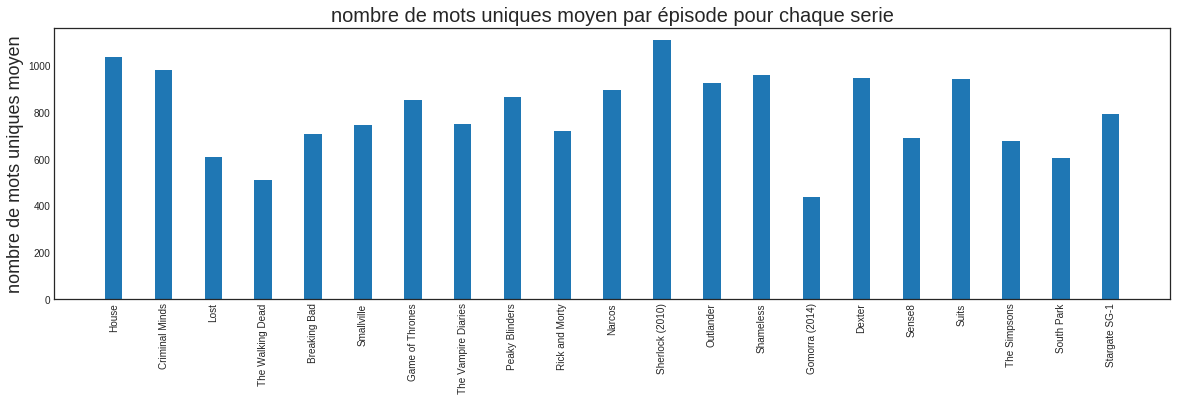

In [74]:
from collections import Counter

nbmots = []
for serie in series:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.tokens")
    lol = 0
    for episode in listepisodes:
        with codecs.open(episode, "r", "utf-8") as file:
            text = file.read()
            lol +=len(Counter(text.split(" ")))
    
    nbmots.append(lol / len(listepisodes))  
    
plt.figure(figsize=(20,5))
plt.ylabel("nombre de mots uniques moyen", fontsize=18)
plt.title("nombre de mots uniques moyen par épisode pour chaque serie", fontsize=20)
plt.bar(range(len(corpus)), nbmots, width=0.35)
plt.xticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
plt.show() 

#### Résultat: 

Mention spéciale à Sherlock qui emploie en moyenne plus de 1000 mots uniques par épisode. Dr House, esprits criminels, shameless ne sont pas loin aussi. On remarque que le nombre de mots uniques par épisode varie du simple au double entre certaines séries. On peut donc penser que cela constituerait un feature intéressant pour caractériser une série et donc un épisode.

## Conclusions:

Les mots trop particuliers à une série peuvent (et doivent) être extraits des séries. Nous pouvons pour cela utiliser une approche basée sur le df, pour extraire ces mots et les ajouter à la liste des stopwords lors des phases de pré traitement.

Les séries diffèrent par leur longueur, richesse de vocabulaire et longueur des répliques. Des critères qui peuvent être utilisés comme feature.